In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import QuantileTransformer


In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_distribution, plot_predictions


In [3]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

file_path = 'data_input_auto/中国汽油表需.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet.columns


Index(['Date', '中国汽油实际消费量', '百度全国迁徙规模指数/7DMA', '全国观影人次/30DMA', '城镇调查失业率',
       '中国服务业PMI/3MMA', '中国新能源车渗透率同差', '中国汽油车销量（辆）超季节性/5年', '传统汽车销量12月移动平均同比',
       '文化旅游体育与传媒支出：当月值/6MMA同比', '财新中国服务业PMI:经营活动指数',
       '中国10年期国债收益率Non-Trend/F0.2', '房地产竣工面积当月值同比', 'WESTPAC中国经济惊喜指数同比'],
      dtype='object')

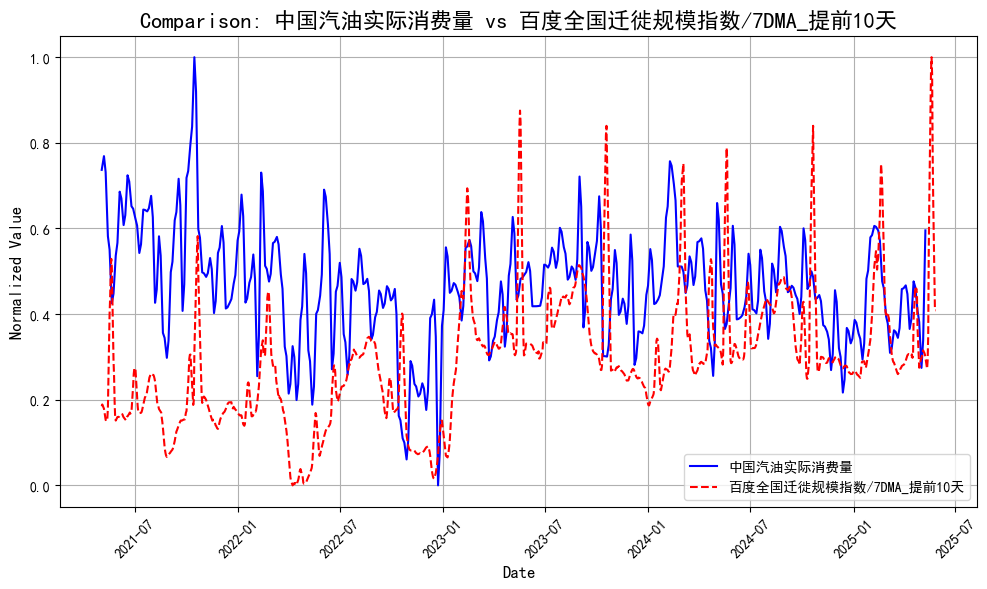

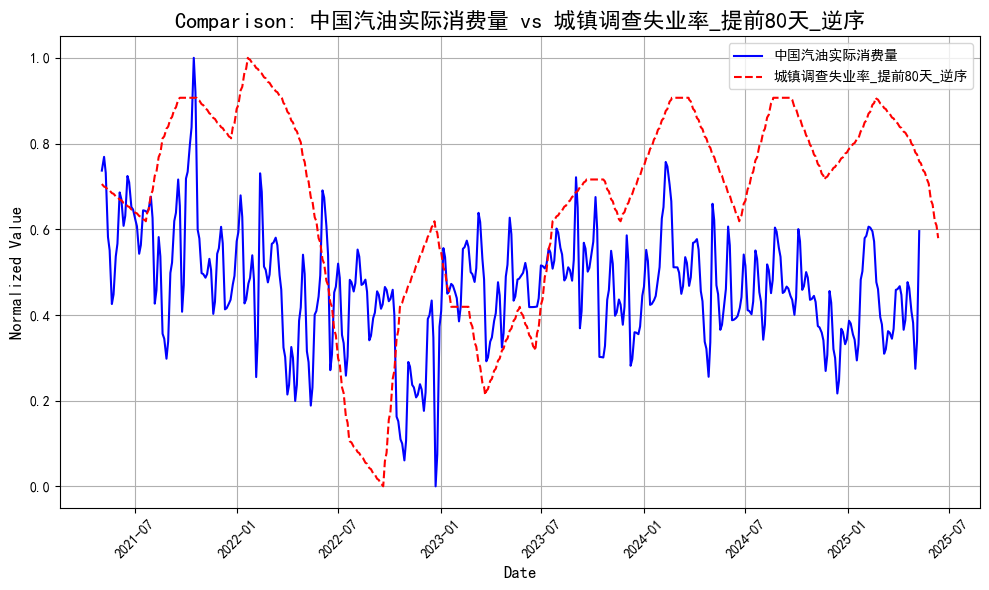

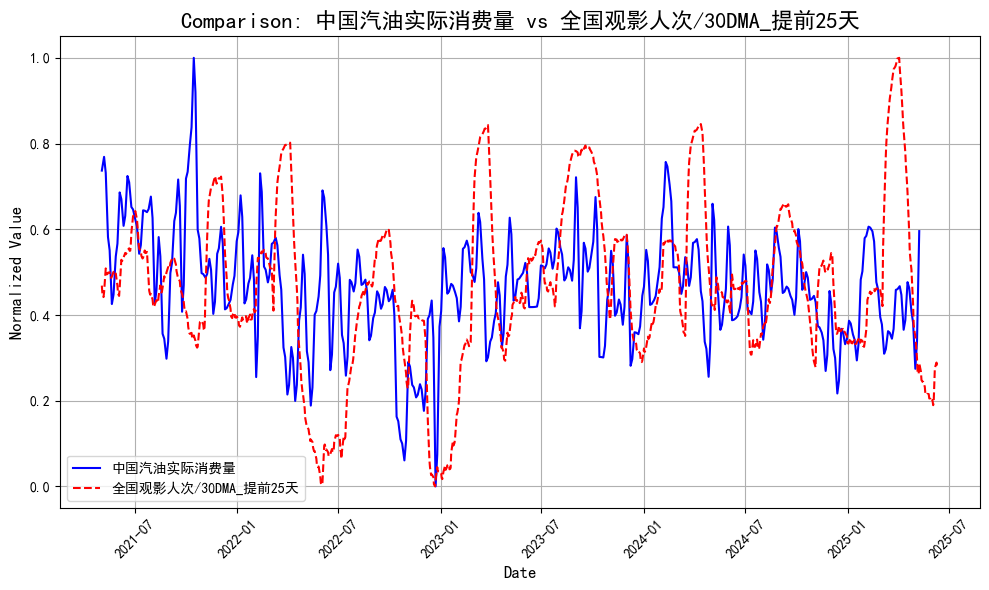

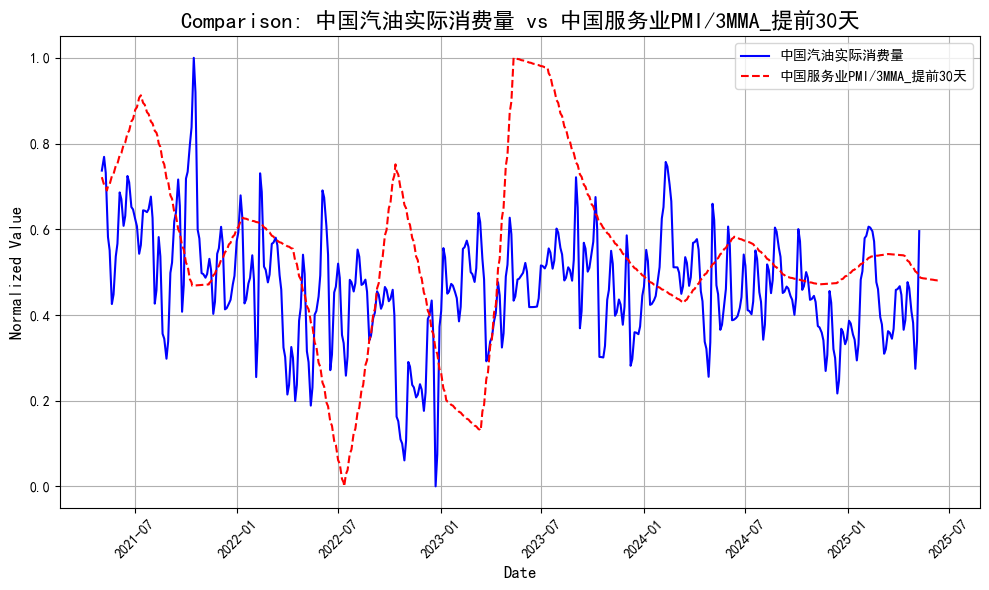

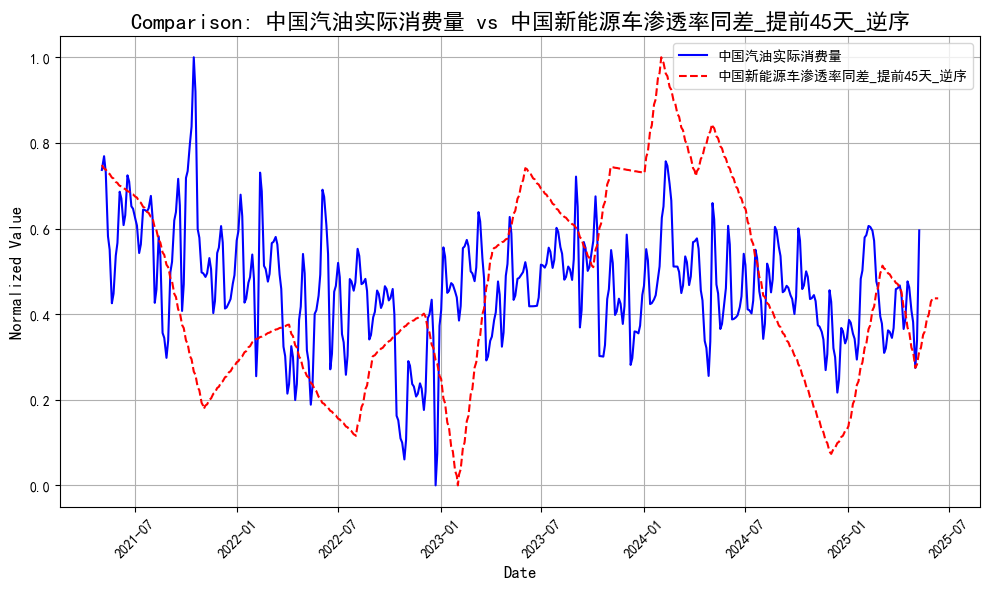

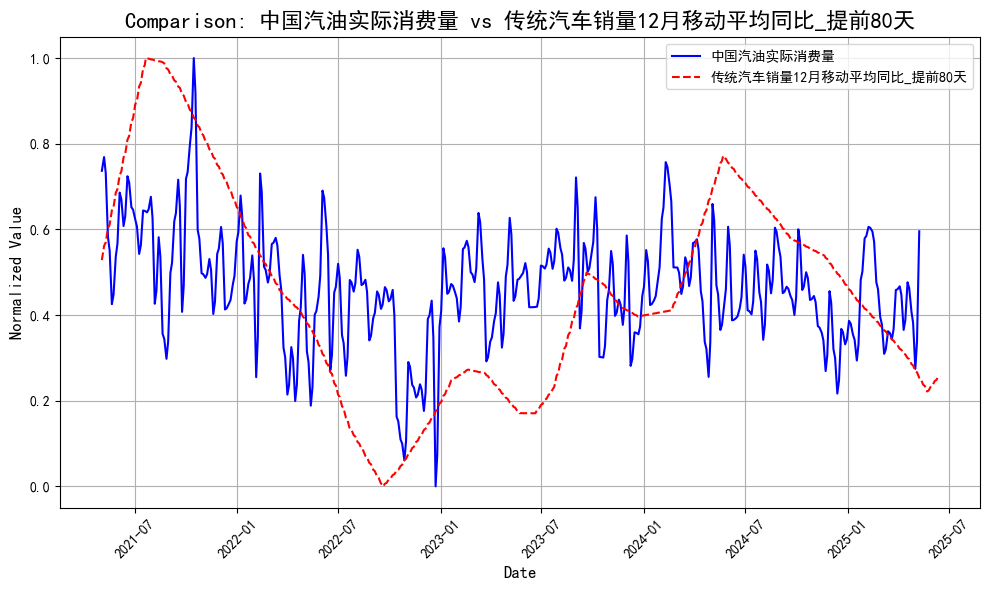

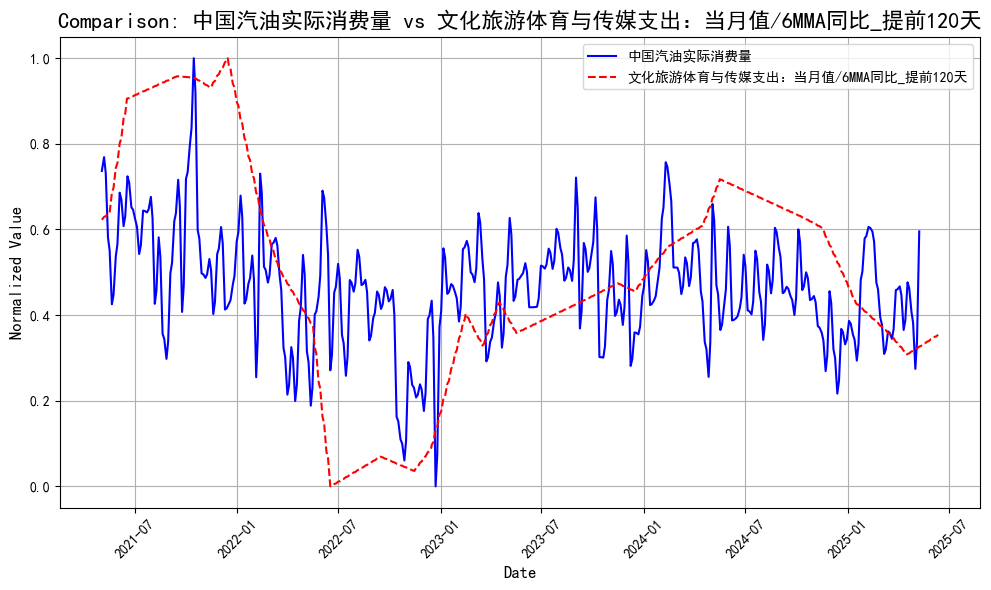

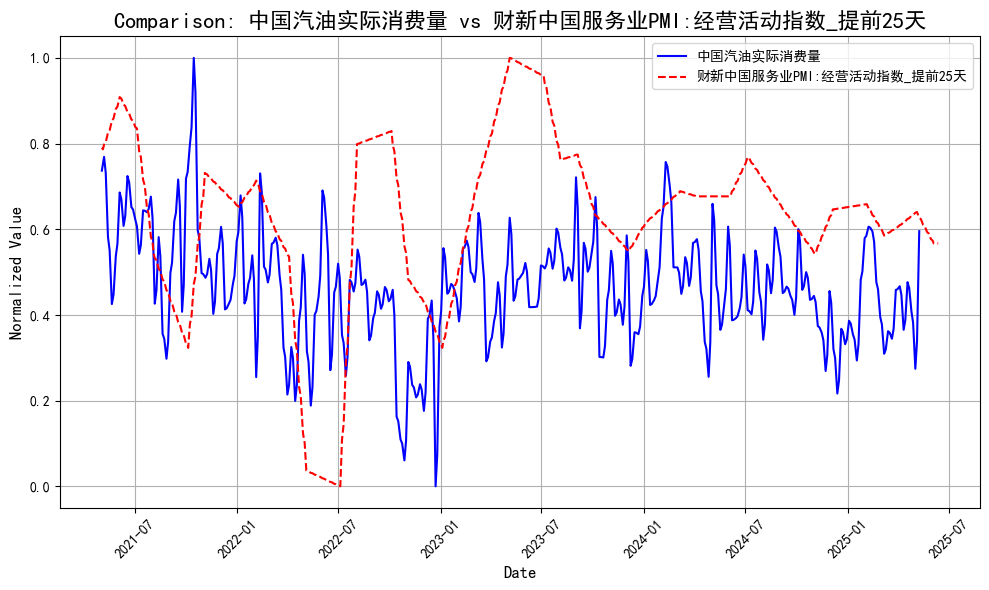

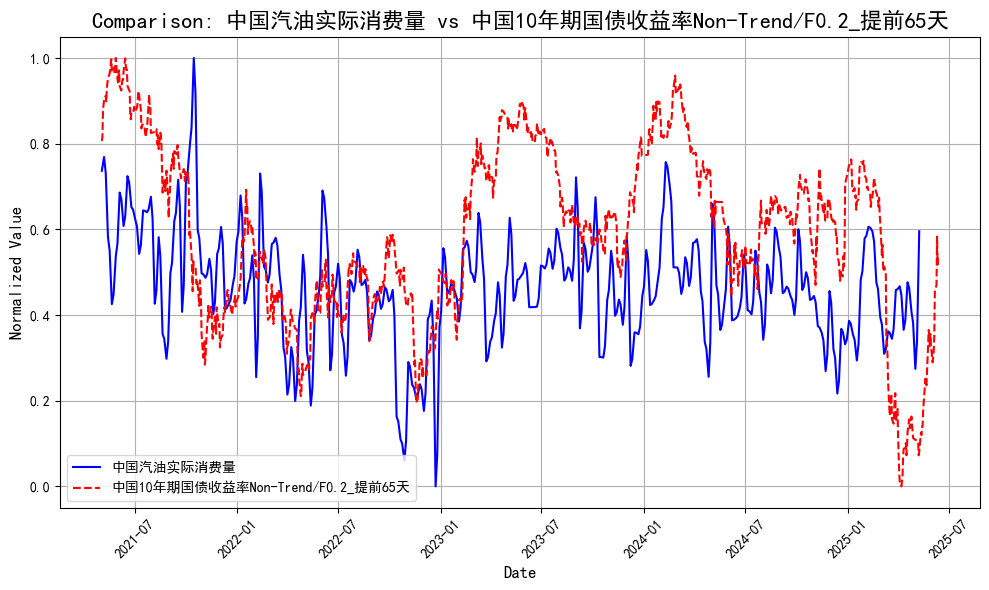

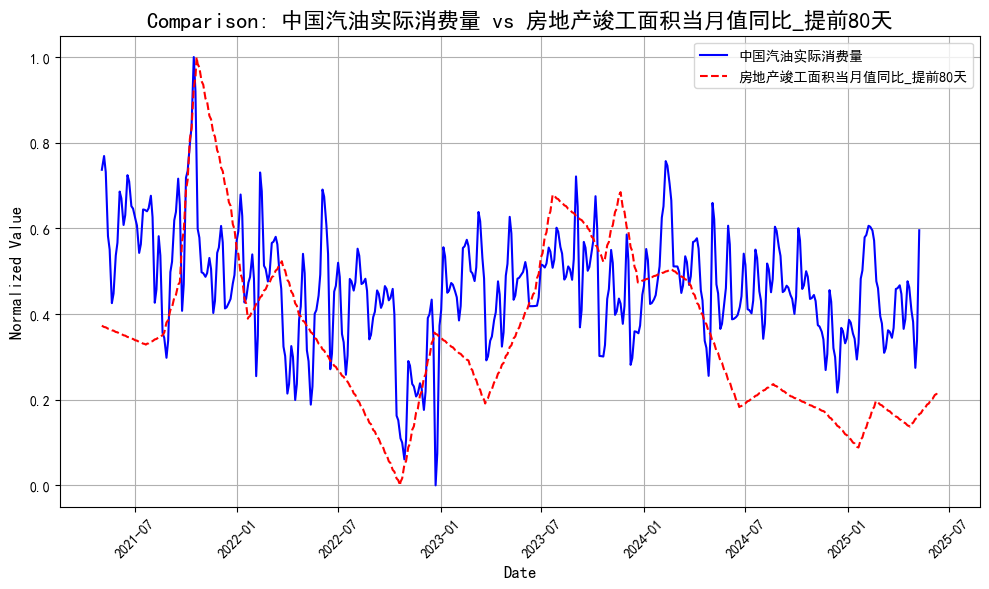

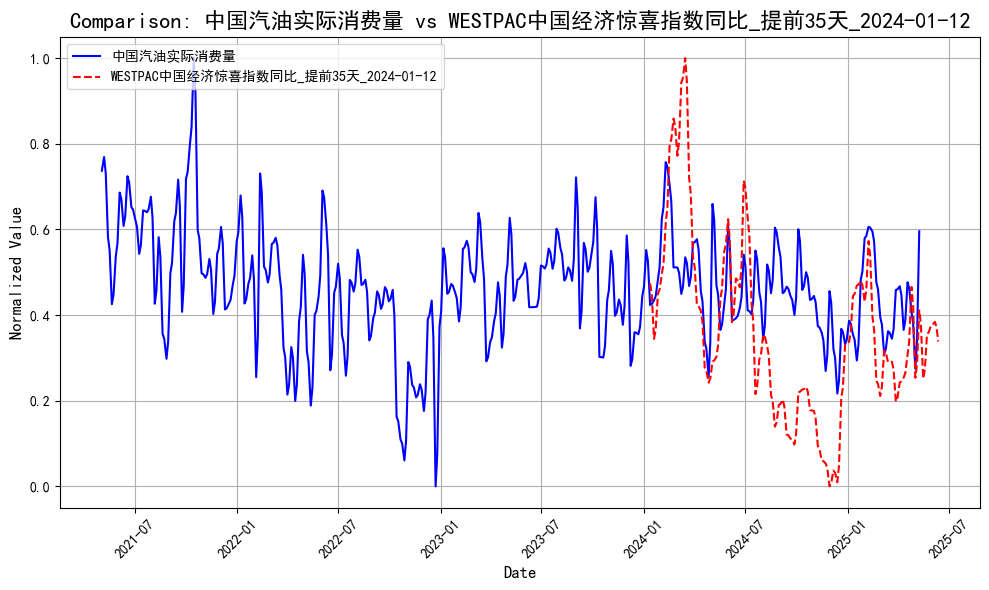

In [4]:
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet.set_index('Date', inplace=True)
last_day = sheet['中国汽油实际消费量'].last_valid_index()
full_date_range = pd.date_range(start=sheet.index.min(), end=sheet.index.max(), freq='B')
sheet = sheet.reindex(full_date_range)


fill_methods = {
    '百度全国迁徙规模指数/7DMA': 'interpolate',
    '全国观影人次/30DMA': 'interpolate',
    '城镇调查失业率':'interpolate',
    '中国服务业PMI/3MMA':'interpolate',
    '中国新能源车渗透率同差':'interpolate',
    '中国汽油车销量（辆）超季节性/5年':'interpolate',
    '传统汽车销量12月移动平均同比':'interpolate',
    '文化旅游体育与传媒支出：当月值/6MMA同比':'interpolate',
    '财新中国服务业PMI:经营活动指数':'interpolate',
    '中国10年期国债收益率Non-Trend/F0.2':'interpolate',
    '房地产竣工面积当月值同比':'interpolate' ,
    'WESTPAC中国经济惊喜指数同比':'interpolate'
} 
sheet.loc[:last_day, '中国汽油实际消费量'] = sheet.loc[:last_day, '中国汽油实际消费量'].interpolate(method='linear')

sheet_daily = fill_missing_values(sheet, fill_methods, return_only_filled=False)

full_date_range1 = pd.date_range(start=sheet_daily.index.min(), end=sheet_daily.index.max()+ pd.Timedelta(days=30), freq='B')
sheet_daily = sheet_daily.reindex(full_date_range1)

sheet_daily['百度全国迁徙规模指数/7DMA_提前10天'] = sheet_daily['百度全国迁徙规模指数/7DMA'].shift(10)
sheet_daily['城镇调查失业率_提前80天'] = sheet_daily['城镇调查失业率'].shift(80)
sheet_daily['中国汽油车销量（辆）超季节性/5年_提前25天'] = sheet_daily['中国汽油车销量（辆）超季节性/5年'].shift(25)
sheet_daily['全国观影人次/30DMA_提前25天'] = sheet_daily['全国观影人次/30DMA'].shift(25)
sheet_daily['中国服务业PMI/3MMA_提前30天'] = sheet_daily['中国服务业PMI/3MMA'].shift(30)
sheet_daily['中国新能源车渗透率同差_提前45天'] = sheet_daily['中国新能源车渗透率同差'].shift(45)
sheet_daily['传统汽车销量12月移动平均同比_提前80天'] = sheet_daily['传统汽车销量12月移动平均同比'].shift(80)
sheet_daily['文化旅游体育与传媒支出：当月值/6MMA同比_提前120天'] = sheet_daily['文化旅游体育与传媒支出：当月值/6MMA同比'].shift(120)
sheet_daily['财新中国服务业PMI:经营活动指数_提前25天'] = sheet_daily['财新中国服务业PMI:经营活动指数'].shift(25)
sheet_daily['中国10年期国债收益率Non-Trend/F0.2_提前65天'] = sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].shift(65)
sheet_daily['房地产竣工面积当月值同比_提前80天'] = sheet_daily['房地产竣工面积当月值同比'].shift(80)
sheet_daily['WESTPAC中国经济惊喜指数同比_提前35天'] = sheet_daily['WESTPAC中国经济惊喜指数同比'].shift(35)

# 先对某个因子进行反向处理
sheet_daily['城镇调查失业率_提前80天_逆序'] = reverse_column(sheet_daily, '城镇调查失业率_提前80天')
sheet_daily['中国新能源车渗透率同差_提前45天_逆序'] = reverse_column(sheet_daily, '中国新能源车渗透率同差_提前45天')

sheet_daily['全国观影人次/30DMA_提前25天'] = np.log1p(sheet_daily['全国观影人次/30DMA_提前25天'])
sheet_daily['中国服务业PMI/3MMA_提前30天'] = sheet_daily['中国服务业PMI/3MMA_提前30天'] ** 2
sheet_daily['城镇调查失业率_提前80天_逆序'] = np.log1p(sheet_daily['城镇调查失业率_提前80天_逆序'])

sheet_daily['WESTPAC中国经济惊喜指数同比_提前35天_2024-01-12'] = np.where(
    sheet_daily.index >= pd.Timestamp('2024-01-12'),
    sheet_daily['WESTPAC中国经济惊喜指数同比_提前35天'],
    np.nan
)


sheet_daily.reset_index(inplace=True)
sheet_daily.rename(columns={'index': 'Date'}, inplace=True)

last_day = sheet_daily['Date'].iloc[sheet_daily['中国汽油实际消费量'].last_valid_index()]
sheet_daily = sheet_daily[sheet_daily['Date'] >= '2021-05-01']
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['中国汽油实际消费量'].notna())
]
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='中国汽油实际消费量', 
    compare_cols=[
        '百度全国迁徙规模指数/7DMA_提前10天','城镇调查失业率_提前80天_逆序',
        '全国观影人次/30DMA_提前25天','中国服务业PMI/3MMA_提前30天','中国新能源车渗透率同差_提前45天_逆序',
        '传统汽车销量12月移动平均同比_提前80天','文化旅游体育与传媒支出：当月值/6MMA同比_提前120天','财新中国服务业PMI:经营活动指数_提前25天',
        '中国10年期国债收益率Non-Trend/F0.2_提前65天','房地产竣工面积当月值同比_提前80天','WESTPAC中国经济惊喜指数同比_提前35天_2024-01-12'
        ]
)

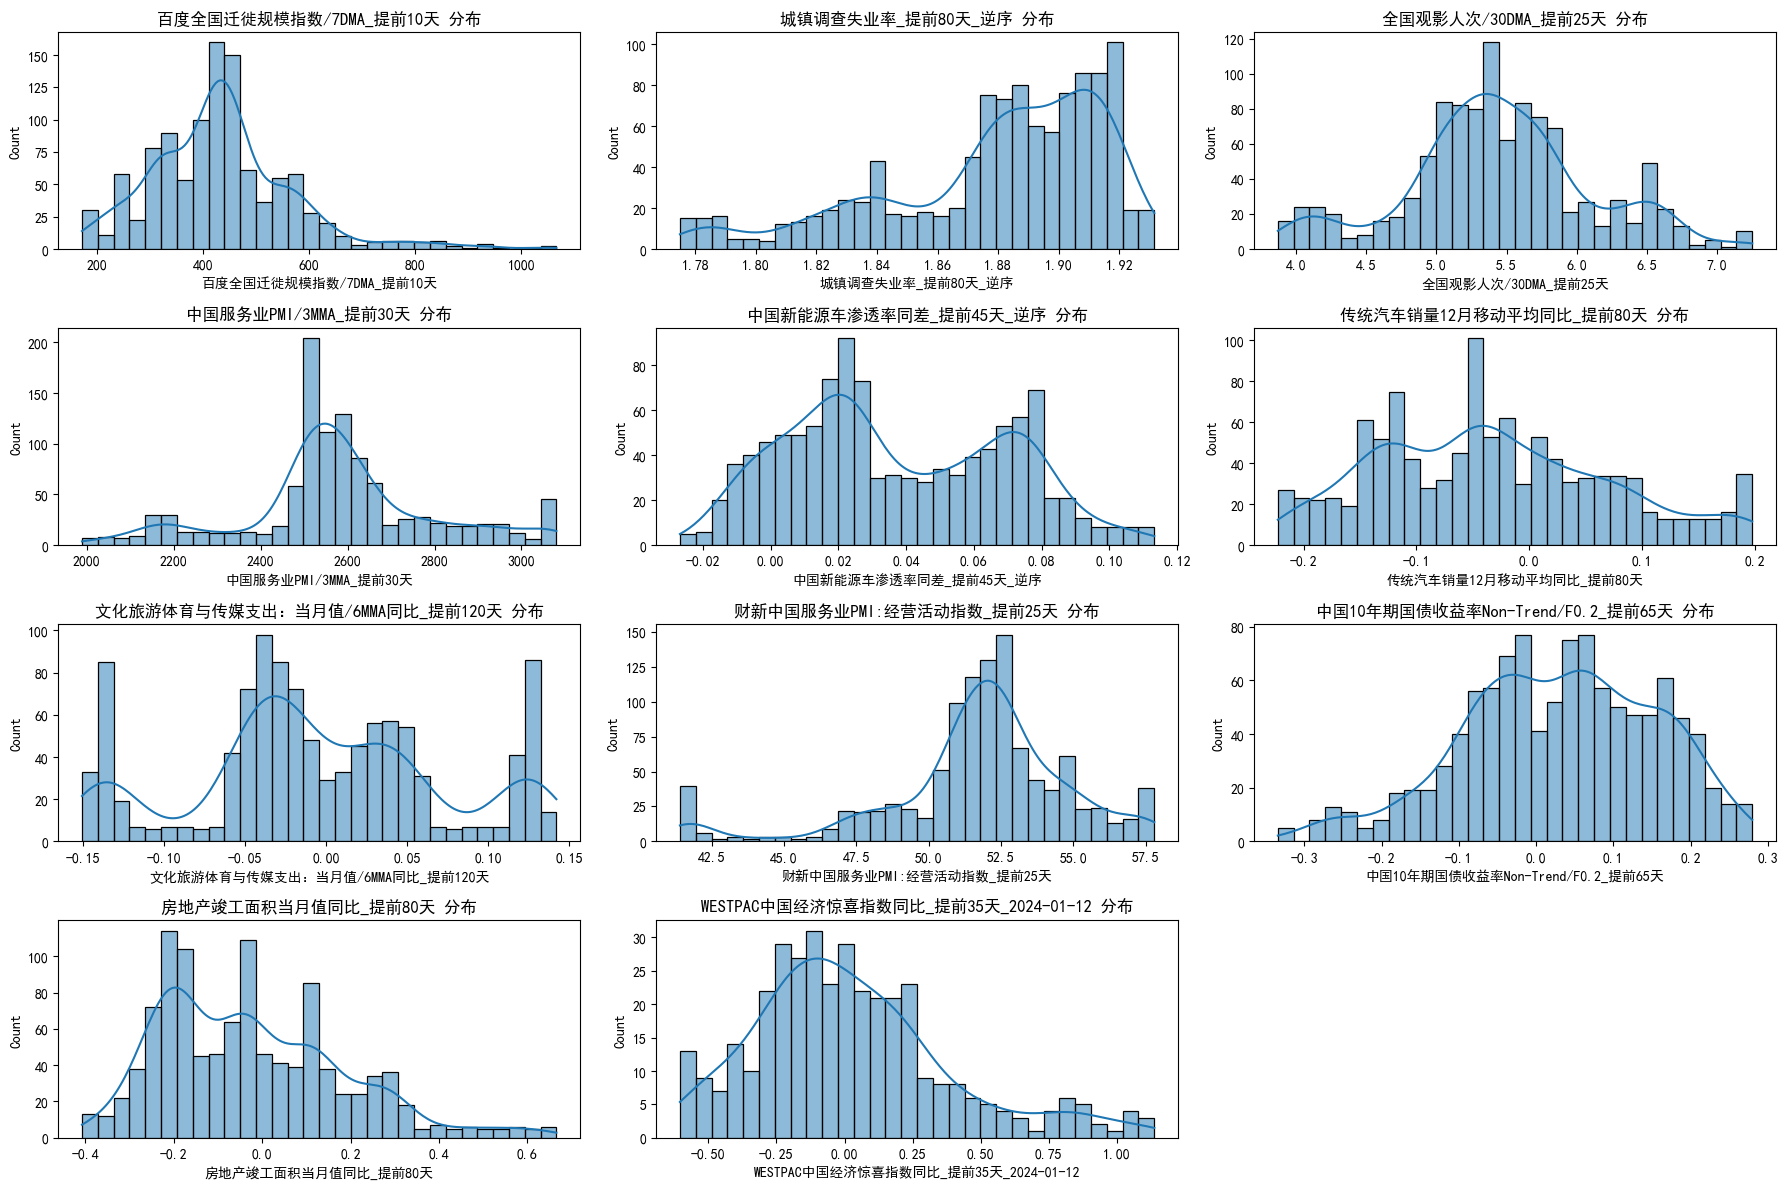

In [5]:
plot_feature_distribution(
    sheet_daily_plot,
    feature_columns = [
        '百度全国迁徙规模指数/7DMA_提前10天','城镇调查失业率_提前80天_逆序',
        '全国观影人次/30DMA_提前25天','中国服务业PMI/3MMA_提前30天','中国新能源车渗透率同差_提前45天_逆序',
        '传统汽车销量12月移动平均同比_提前80天','文化旅游体育与传媒支出：当月值/6MMA同比_提前120天','财新中国服务业PMI:经营活动指数_提前25天',
        '中国10年期国债收益率Non-Trend/F0.2_提前65天','房地产竣工面积当月值同比_提前80天','WESTPAC中国经济惊喜指数同比_提前35天_2024-01-12'
] )

In [6]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 50
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

# 因子集
feature_columns = [
        '百度全国迁徙规模指数/7DMA_提前10天',
        '城镇调查失业率_提前80天_逆序',
        '全国观影人次/30DMA_提前25天',
        '中国服务业PMI/3MMA_提前30天',
        '中国新能源车渗透率同差_提前45天_逆序',
        '传统汽车销量12月移动平均同比_提前80天',
        '文化旅游体育与传媒支出：当月值/6MMA同比_提前120天',
        '财新中国服务业PMI:经营活动指数_提前25天',
        '中国10年期国债收益率Non-Trend/F0.2_提前65天',
        '房地产竣工面积当月值同比_提前80天',
        'WESTPAC中国经济惊喜指数同比_提前35天_2024-01-12'
]
# 预测目标column
predict_column = '中国汽油实际消费量'

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns].copy()
y_train = train_data[predict_column]

X_test = test_data[feature_columns].copy()
y_test = test_data[predict_column]

X_future = future_data[feature_columns].copy()

'''
######################################## 因子权重调节 #################################
feature_weights_dict = {
    '中国新能源车渗透率同差_提前45天_逆序': 10000,
}

# 初始化所有因子的权重为1（与 feature_columns 顺序一致）
feature_weights = np.ones(len(feature_columns))

# 根据字典更新指定因子的权重
for feature, weight in feature_weights_dict.items():
    if feature in feature_columns:
        idx = feature_columns.index(feature)
        feature_weights[idx] = weight

# 打印每个因子的权重，便于检查
for feature, weight in zip(feature_columns, feature_weights):
    print(f"{feature}: {weight}")

# 将权重应用到原始数据上（所有数据均乘以对应的权重）
for idx, feature in enumerate(feature_columns):
    weight = feature_weights[idx]
    X_train.loc[:,feature] = X_train.loc[:,feature] * weight
    X_test.loc[:,feature] = X_test.loc[:,feature] * weight
    X_future.loc[:,feature] = X_future.loc[:,feature] * weight
########################################################################################################################


######################################## 指定哪些因子 不需要 因子标准化 #################################

# 定义不进行标准化的因子列表（这里以‘全国观影人次/30DMA_提前25天’为例，可根据需要添加其他因子）
non_scaled_features = ['中国新能源车渗透率同差_提前45天_逆序']

# 得到需要标准化的特征列表
scaled_features = [col for col in feature_columns if col not in non_scaled_features]

# 分别提取需要标准化的部分数据
X_train_to_scale = X_train[scaled_features]
X_test_to_scale = X_test[scaled_features]
X_future_to_scale = X_future[scaled_features]

# 初始化 StandardScaler 并对待标准化特征进行拟合和转换
scaler = StandardScaler()
X_train_scaled_part = scaler.fit_transform(X_train_to_scale)
X_test_scaled_part = scaler.transform(X_test_to_scale)
X_future_scaled_part = scaler.transform(X_future_to_scale)

# 将转换后的数据合并回原始 DataFrame，保证未标准化的因子保持原始数据
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_future_scaled = X_future.copy()

X_train_scaled.loc[:, scaled_features] = X_train_scaled_part
X_test_scaled.loc[:, scaled_features] = X_test_scaled_part
X_future_scaled.loc[:, scaled_features] = X_future_scaled_part
########################################################################################################################
'''
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)


# 创建DMatrix对象,设置样本权重以降低异常值的影响
train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.05,  # 较小的学习率
    'max_depth': 3,  # 控制树的深度防止过拟合
    'min_child_weight': 5,  # 控制过拟合
    'subsample': 0.9,  # 随机采样防止过拟合
    'colsample_bytree': 0.9,  # 特征随机采样
    'gamma': 0.5,  # 控制分裂
    'reg_alpha': 0.8,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}


# 训练模型，使用早停策略，最大训练轮数
num_boost_round = 1000
# 记录评估指标、存储
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  
    num_boost_round,
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')], 
    early_stopping_rounds=100, 
    evals_result=evals_result,  
    verbose_eval=100 
)

# 训练集预测
y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix


################################# Xgboost 模型 训练 测试 预测 所有数据 #################################

# 确保数据拼接后索引是连续的，防止数据对不齐
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

'''
X_all_scaled = pd.concat([X_train_scaled, X_test_scaled]).reset_index(drop=True)
'''
# 对所有数据进行标准化（使用之前拟合的 scaler）
X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)


# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)


# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重
# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=30,
    evals_result=evals_result,
    verbose_eval=100
)

# 对全部数据进行预测（X_train + X_test）
y_all_pred = model_all.predict(all_data_dmatrix)

# 对未来数据进行预测
y_future_pred_all = model_all.predict(future_dmatrix_all)

# 计算全部数据的 MSE 和 R² 分数
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

# 打印结果
print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred

# 存储未来预测结果
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	eval-rmse:23.86946	train-rmse:29.85951


[100]	eval-rmse:21.73216	train-rmse:15.32922


[200]	eval-rmse:22.35163	train-rmse:11.86478


[300]	eval-rmse:22.49903	train-rmse:9.49868


[400]	eval-rmse:22.71894	train-rmse:7.86847


[500]	eval-rmse:22.99176	train-rmse:6.69159


[600]	eval-rmse:23.10662	train-rmse:5.86314


[700]	eval-rmse:23.35148	train-rmse:5.13820

[800]	eval-rmse:23.39573	train-rmse:4.59361

[900]	eval-rmse:23.65058	train-rmse:4.17273


[999]	eval-rmse:23.65787	train-rmse:3.81210

训练集 MSE (DMatrix): 15.9391, 训练集 R² (DMatrix): 0.9851
测试集 MSE (DMatrix): 559.6949, 测试集 R² (DMatrix): -1.1844
[0]	train-rmse:29.57209


[100]	train-rmse:15.34775

[200]	train-rmse:11.96278

[300]	train-rmse:9.68182

[400]	train-rmse:8.04782


[500]	train-rmse:6.85840

[600]	train-rmse:5.95440

[700]	train-rmse:5.29237

[800]	train-rmse:4.73868

[900]	train-rmse:4.30748

[999]	train-rmse:3.94843


全部数据 MSE: 17.0747, 全部数据 R²: 0.9837


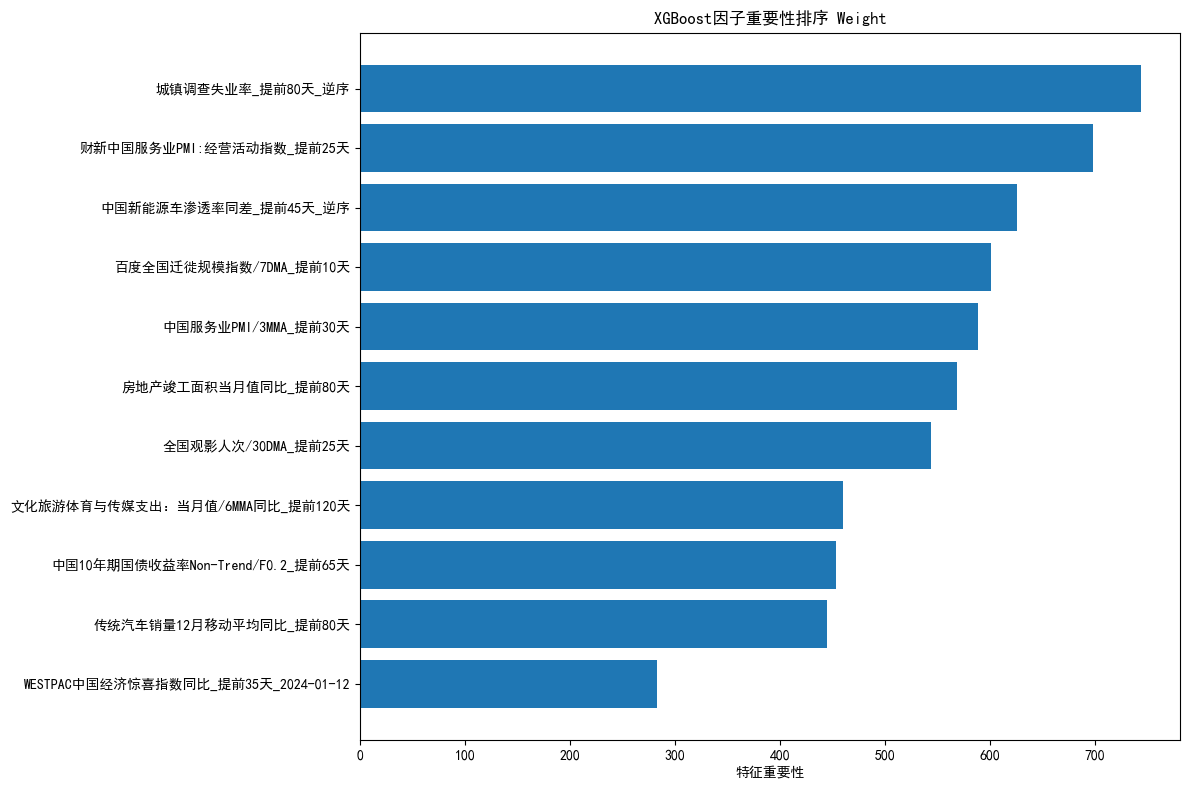

In [7]:

# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'weight'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 Weight')
plt.tight_layout()
plt.show()


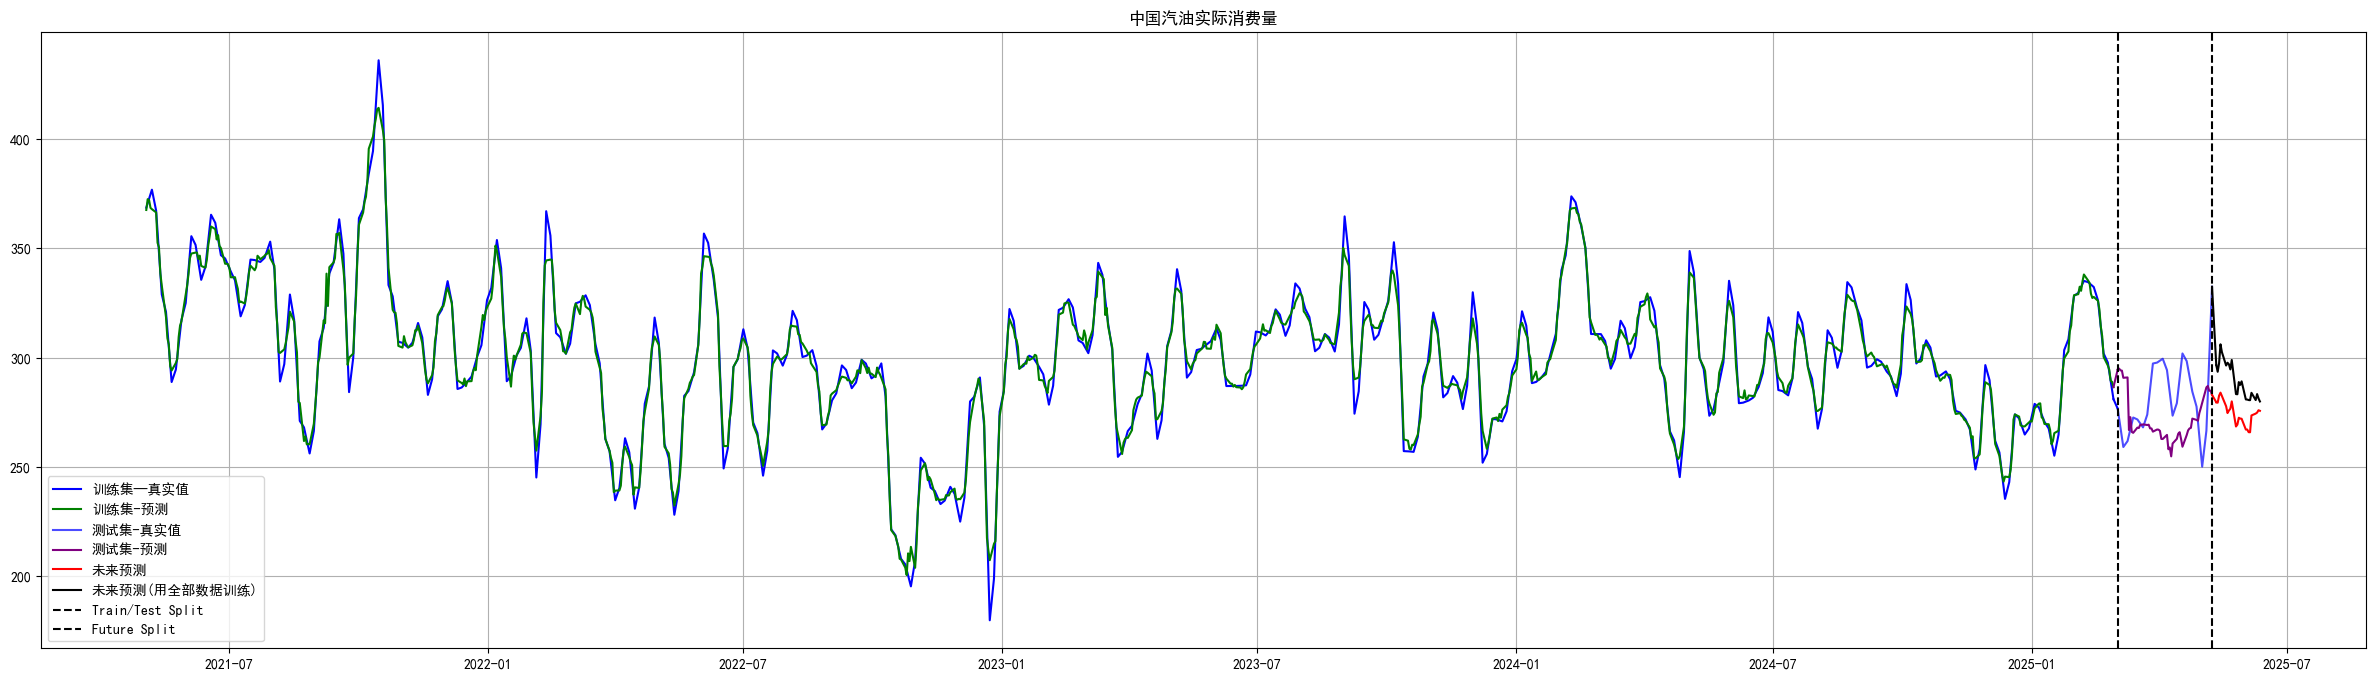

In [8]:
################################# 可视化 #################################

# 创建一个新的图形
plt.figure(figsize=(30, 8))

# 训练集和测试集的连接点(预测值)
train_last_date = train_data['Date'].iloc[-1]
test_first_date = test_data['Date'].iloc[0]
train_last_value = y_train_pred_dmatrix[-1]
test_first_value = y_test_pred_dmatrix[0]

# 训练集和测试集的连接点(真实值)
train_last_date_real = train_data['Date'].iloc[-1]
test_first_date_real = test_data['Date'].iloc[0]
train_last_value_real = y_train.iloc[-1]
test_first_value_real = y_test.iloc[0]

# 测试集和未来集的连接点(普通预测)
test_last_date = test_data['Date'].iloc[-1]
future_first_date = future_data['Date'].iloc[0]
test_last_value = y_test_pred_dmatrix[-1]
future_first_value = future_data['预测值'].iloc[0]

# 测试集和未来集的连接点(全量预测)
test_last_date_all = test_data['Date'].iloc[-1]
future_first_date_all = future_data['Date'].iloc[0]
test_last_value_all = y_test.iloc[-1]
future_first_value_all = future_data['预测值_全量'].iloc[0]

# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加连接线
plt.plot([train_last_date, test_first_date], [train_last_value, test_first_value], color='purple')
plt.plot([test_last_date, future_first_date], [test_last_value, future_first_value], color='red')
plt.plot([train_last_date_real, test_first_date_real], [train_last_value_real, test_first_value_real], color='blue')
plt.plot([test_last_date_all, future_first_date_all], [test_last_value_all, future_first_value_all], color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('中国汽油实际消费量')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# 添加未来预测值
future_predictions = future_data[['Date', '预测值']].copy()
future_predictions.columns = ['Date', '中国汽油实际消费量']

future_predictions.to_excel('data_output_auto/中国汽油实际消费量预测结果.xlsx', index=False)

---

In [10]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并历史真实值和预测值
merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
# 按日期排序 倒叙
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel 在 eta 文件夹里
merged_df_daily.to_excel('eta/中国汽油表需_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/中国汽油表需_月度数据.xlsx', index=False, float_format='%.4f')

---

In [11]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国汽油表需"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [12]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国汽油表需"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件
